In [1]:
# Cell 1: imports & config
import os, time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Config
DATA_ROOT = "../fer2013"    # change if your extracted folder is elsewhere
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

NUM_EPOCHS = 8              # start small; increase if you have time
BATCH_SIZE = 64
LR = 1e-4
NUM_WORKERS = 4             # set 0 on Windows if you get issues
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
np.random.seed(SEED)

print("Device:", device)


Device: cuda


In [15]:
# Cell 2: Data Transforms and Dataloaders

# Define image transformations for training and testing
# Cell 2: Data transforms and loaders

transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 👈 Add this line
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 👈 Add this line
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Load datasets
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform_train)
test_dataset  = datasets.ImageFolder(root=TEST_DIR,  transform=transform_test)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Print dataset info
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print("Classes:", train_dataset.classes)


Train samples: 28709
Test samples: 7178
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


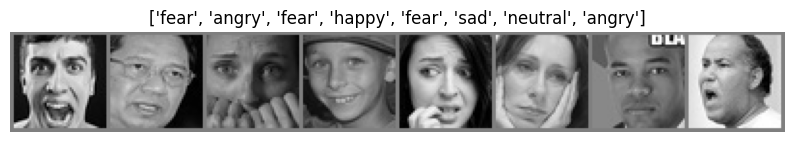

In [16]:
# Cell 3: Visualize sample training images

def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]), 
        title=[train_dataset.classes[labels[j]] for j in range(8)])


In [17]:
# Cell 4: Define a simple baseline CNN model
import torch.nn as nn
import torch.nn.functional as F

class CNNBaseline(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNBaseline, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # -> [32, 24, 24]
        x = self.pool(F.relu(self.conv2(x)))   # -> [64, 12, 12]
        x = self.pool(F.relu(self.conv3(x)))   # -> [128, 6, 6]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate model
model = CNNBaseline(num_classes=7).to(device)
print(model)


CNNBaseline(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)


In [18]:
# Cell 5: Training loop for baseline CNN

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses, test_losses, accuracies = [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Evaluate on test data
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_loader)
    epoch_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    accuracies.append(accuracy)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Test Loss: {epoch_test_loss:.4f} | "
          f"Accuracy: {accuracy:.2f}%")

print("\nTraining complete ✅")


Epoch [1/8] Train Loss: 1.7538 | Test Loss: 1.6410 | Accuracy: 36.44%
Epoch [2/8] Train Loss: 1.6111 | Test Loss: 1.5476 | Accuracy: 42.13%
Epoch [3/8] Train Loss: 1.5388 | Test Loss: 1.4773 | Accuracy: 43.80%
Epoch [4/8] Train Loss: 1.4864 | Test Loss: 1.4410 | Accuracy: 45.07%
Epoch [5/8] Train Loss: 1.4456 | Test Loss: 1.4022 | Accuracy: 46.41%
Epoch [6/8] Train Loss: 1.4094 | Test Loss: 1.3665 | Accuracy: 47.28%
Epoch [7/8] Train Loss: 1.3772 | Test Loss: 1.3413 | Accuracy: 48.47%
Epoch [8/8] Train Loss: 1.3495 | Test Loss: 1.3222 | Accuracy: 48.89%

Training complete ✅


In [2]:
# ---- Phase 1: Model 2 (ResNet18 Transfer Learning) ----

# New transforms (ResNet expects 3 channels, 224x224)
transform_train_resnet = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test_resnet = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Use distinct variable names to avoid conflict with baseline CNN
train_dataset_resnet = datasets.ImageFolder(TRAIN_DIR, transform=transform_train_resnet)
test_dataset_resnet  = datasets.ImageFolder(TEST_DIR, transform=transform_test_resnet)

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader_resnet  = DataLoader(test_dataset_resnet, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train samples (ResNet): {len(train_dataset_resnet)}")
print(f"Test samples (ResNet): {len(test_dataset_resnet)}")
print(f"Classes: {train_dataset_resnet.classes}")


Train samples (ResNet): 28709
Test samples (ResNet): 7178
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [3]:
# ---- Phase 1: Model 2 (ResNet18 Fine-tuning) ----

from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch

# ✅ Load pretrained ResNet18
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# ✅ Modify the final fully connected layer for 7 emotion classes
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 7)

# ✅ Unfreeze only deeper layers (layer3, layer4, fc)
for name, param in resnet18.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

resnet18 = resnet18.to(device)

# ✅ Define loss and optimizer (smaller LR)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet18.parameters()), lr=1e-4)

# ✅ Training function (same as before)
def train_resnet(model, train_loader, test_loader, epochs=25):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # ✅ Evaluation
        model.eval()
        correct, total = 0, 0
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {running_loss/len(train_loader):.4f} | "
              f"Test Loss: {test_loss/len(test_loader):.4f} | "
              f"Accuracy: {acc:.2f}%")

    print("✅ ResNet18 fine-tuning complete!")

# ✅ Train ResNet18 using ResNet loaders
train_resnet(resnet18, train_loader_resnet, test_loader_resnet, epochs=25)


Epoch [1/25] Train Loss: 1.1508 | Test Loss: 1.0006 | Accuracy: 61.84%
Epoch [2/25] Train Loss: 0.8530 | Test Loss: 0.9519 | Accuracy: 64.60%
Epoch [3/25] Train Loss: 0.6552 | Test Loss: 1.0069 | Accuracy: 65.09%
Epoch [4/25] Train Loss: 0.4697 | Test Loss: 1.0953 | Accuracy: 64.47%
Epoch [5/25] Train Loss: 0.3300 | Test Loss: 1.1651 | Accuracy: 65.06%
Epoch [6/25] Train Loss: 0.2277 | Test Loss: 1.2983 | Accuracy: 63.95%
Epoch [7/25] Train Loss: 0.1646 | Test Loss: 1.3463 | Accuracy: 64.45%
Epoch [8/25] Train Loss: 0.1230 | Test Loss: 1.4836 | Accuracy: 65.19%
Epoch [9/25] Train Loss: 0.0988 | Test Loss: 1.5104 | Accuracy: 64.59%
Epoch [10/25] Train Loss: 0.0878 | Test Loss: 1.5778 | Accuracy: 65.17%
Epoch [11/25] Train Loss: 0.0781 | Test Loss: 1.5973 | Accuracy: 64.57%
Epoch [12/25] Train Loss: 0.0720 | Test Loss: 1.6361 | Accuracy: 65.25%
Epoch [13/25] Train Loss: 0.0607 | Test Loss: 1.6475 | Accuracy: 65.31%
Epoch [14/25] Train Loss: 0.0668 | Test Loss: 1.7708 | Accuracy: 65.24%
E

In [6]:
import os

# Create a directory named 'trained_models' if it doesn’t exist
os.makedirs("trained_models", exist_ok=True)

# ✅ Save model weights
torch.save(resnet18.state_dict(), "trained_models/resnet18_finetuned.pth")

# ✅ Save checkpoint (model + optimizer + epoch)
torch.save({
    'model_state_dict': resnet18.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 25   # or whatever number of epochs you trained
}, "trained_models/resnet18_checkpoint.pth")

print("✅ Model saved successfully inside 'trained_models/' folder!")


✅ Model saved successfully inside 'trained_models/' folder!
